In [1]:
import xarray as xr

import numpy as np

import scipy.stats as stats

import pandas as pd

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

import glob

import datetime

import matplotlib.pyplot as plt

import pickle

import cartopy.crs as ccrs

import cartopy.feature as cfeature

from scipy.stats import spearmanr

import seaborn as sns

import os

import matplotlib.colors as mcolors

from matplotlib.colors import TwoSlopeNorm

from sklearn.metrics import silhouette_score

from scipy.stats import pearsonr

from pathlib import Path

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
# Define the path to the saved buoyancy arrays

output_path = Path.home() / "limited_domain_buoyancy_arrays" / "computed_buoyancy.npz"

# load the saved buoyancy arrays

data = np.load(output_path)

# extract the arrays

blt = data["all_blt"]

blc = data["all_blc"]

print("Buoyancy arrays loaded successfully!")

Buoyancy arrays loaded successfully!


In [5]:
lats = np.arange(39, 29.75, -0.25)

lons = np.arange(-105, -94.75, 0.25) 

# Divide into 10 equal sections (10 edges means 11 bin edges)

lat_bins = np.linspace(lats.min(), lats.max(), 11)  

lon_bins = np.linspace(lons.min(), lons.max(), 11)

# Compute the center of each section

lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2

lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2

# Find the closest grid indices to these centers

lat_indices = [np.argmin(np.abs(lats - lc)) for lc in lat_centers]

lon_indices = [np.argmin(np.abs(lons - lc)) for lc in lon_centers]

selected_lats = lats[lat_indices]

selected_lons = lons[lon_indices]

selected_grid_points = [(lat, lon) for lat in selected_lats for lon in selected_lons]

times = pd.date_range("2001-05-01", "2018-09-30", freq="D")

times = times[(times.month >= 5) & (times.month <= 9)]  # Filter months 5-9

times = [d.date() for d in times]  # Convert to datetime.date format

In [6]:
with open('ape_df.pkl', 'rb') as f:
    
    fullape_df = pickle.load(f)


ape_df = fullape_df[
    
    (fullape_df['latitude'].isin(selected_lats)) & 
    
    (fullape_df['longitude'].isin(selected_lons)) & 
    
    (fullape_df['date'].isin(times)) & 
    
    (fullape_df['APE'])

].reset_index(drop=True)

nonape_df = fullape_df[
    
    (fullape_df['latitude'].isin(selected_lats)) & 
    
    (fullape_df['longitude'].isin(selected_lons)) & 
    
    (fullape_df['date'].isin(times)) & 
    
    (~fullape_df['APE'])

].reset_index(drop=True)

allcases_df = fullape_df[
    
    (fullape_df['latitude'].isin(selected_lats)) & 
    
    (fullape_df['longitude'].isin(selected_lons)) & 
    
    (fullape_df['date'].isin(times))

].reset_index(drop=True)

print(ape_df.shape, nonape_df.shape, allcases_df.shape)


(79360, 6) (196040, 6) (275400, 6)


In [7]:
allcases_df["max_precip_amount"] = allcases_df["daily_precip"].apply(lambda x: np.max(x) 
                                                           
                                                           if isinstance(x, np.ndarray) 
                                                           
                                                           and x.size > 0 else np.nan)

In [10]:
num_times = len(times)

lat_grid, lon_grid = np.meshgrid(selected_lats, selected_lons, indexing="ij")

time_expanded = np.repeat(times, 10 * 10)

lat_expanded = np.tile(lat_grid.flatten(), num_times)

lon_expanded = np.tile(lon_grid.flatten(), num_times)

# flatten blc and blt

blc_flat = blc.flatten()

blt_flat = blt.flatten()

buoyancy_df = pd.DataFrame({
    
    "date": time_expanded,
    
    "latitude": lat_expanded,
    
    "longitude": lon_expanded,
    
    "blc": blc_flat,
    
    "blt": blt_flat
})

ape_wb = ape_df.merge(buoyancy_df, on=["date", "latitude", "longitude"], how="left")

nonape_wb = nonape_df.merge(buoyancy_df, on=["date", "latitude", "longitude"], how="left")

allcases_wb = allcases_df.merge(buoyancy_df, on=["date", "latitude", "longitude"], how="left")

print(ape_wb.shape, nonape_wb.shape, allcases_wb.shape)

(79360, 8) (196040, 8) (275400, 9)


In [11]:
# calculating climatology for every calendar day and every gridpoint 

allcases_wb['date'] = pd.to_datetime(allcases_wb['date'])

allcases_wb['day_month'] = allcases_wb['date'].dt.strftime('%m-%d')

clim = allcases_wb.groupby(['latitude', 'longitude', 'day_month'], as_index=False)[['blc', 'blt']].agg(['mean', 'std', 'count'])

clim.columns = ['_'.join(col).strip() for col in clim.columns]

clim.rename(columns={"latitude_": "latitude", "longitude_": "longitude", "day_month_": "day_month"}, inplace=True)

df = allcases_wb.merge(clim, on=["latitude", "longitude", "day_month"], how="left")

df["blt_stnd_anom"] = (df["blt"] - df["blt_mean"]) / df["blt_std"]

df["blc_stnd_anom"] = (df["blc"] - df["blc_mean"]) / df["blc_std"]

In [35]:
apes = df[df['APE'] == True]

nonapes = df[df['APE'] == False]

apes_grouped = apes.groupby(["latitude", "longitude"], as_index=False)[['blc', 'blt']].mean()

non_apes_grouped = nonapes.groupby(["latitude", "longitude"], as_index=False)[['blc', 'blt']].mean()

difference = apes_grouped[['latitude', 'longitude', 'blc', 'blt']].copy()

difference['blc'] = apes_grouped['blc'] - non_apes_grouped['blc']

difference['blt'] = apes_grouped['blt'] - non_apes_grouped['blt']

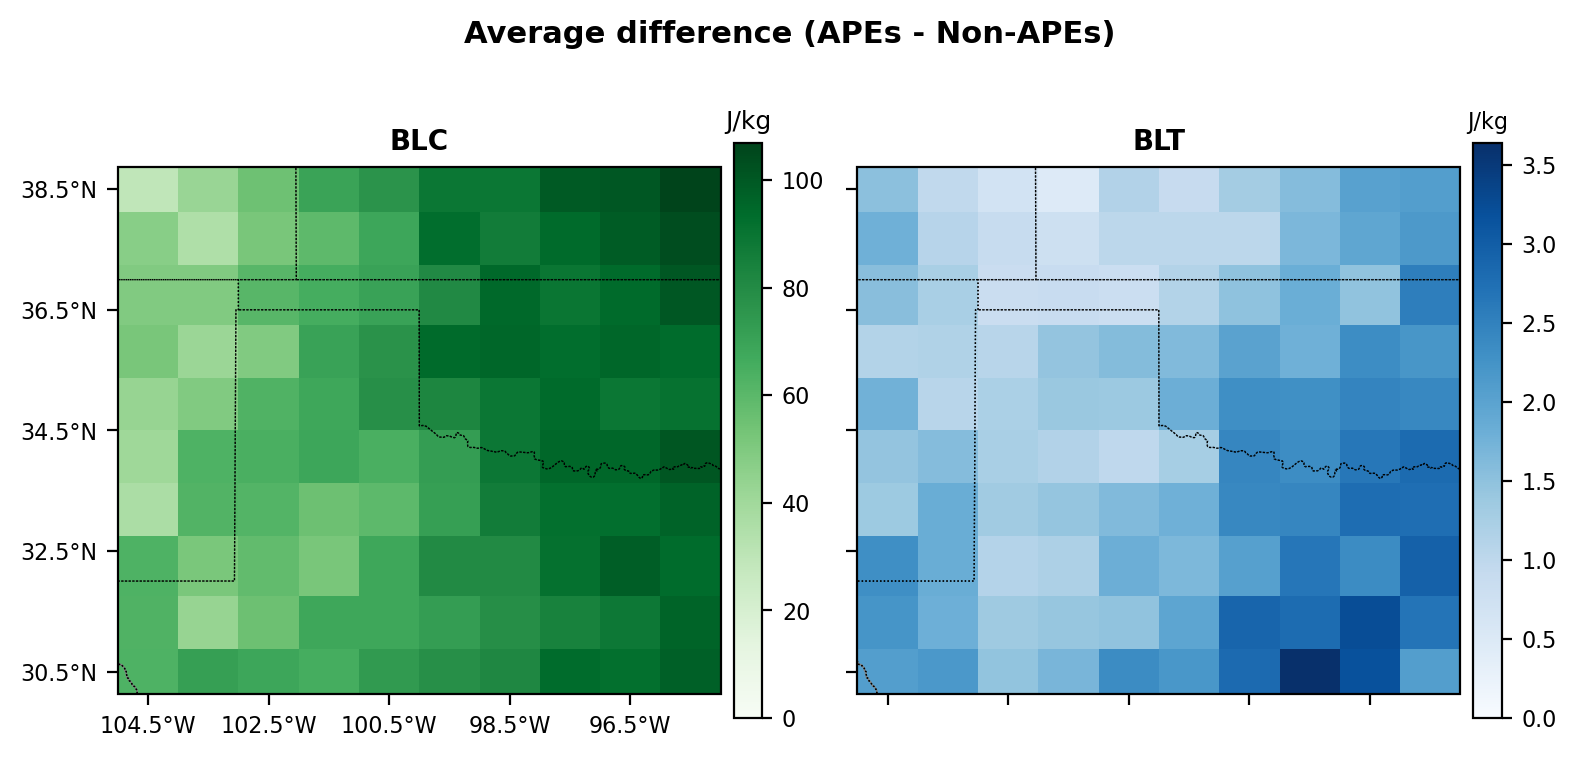

In [44]:
lats = np.sort(difference["latitude"].unique())

lons = np.sort(difference["longitude"].unique())

blc_grid = difference.pivot(index="latitude", columns="longitude", values="blc").values

blt_grid = difference.pivot(index="latitude", columns="longitude", values="blt").values

norm_blc = plt.Normalize(vmin=0, vmax=np.max(blc_grid))

norm_blt = plt.Normalize(vmin=0, vmax=np.max(blt_grid))

def plot_heatmap(ax, data, title, norm, cmap, label_ticks=True):
    
    mesh = ax.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, shading="auto")
    
    ax.coastlines(linewidth=0.8)
    
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=0.6, edgecolor="gray")
    
    ax.add_feature(cfeature.STATES, linestyle=":", linewidth=0.5, edgecolor="black")
    
    ax.set_xticks(np.arange(np.min(lons), np.max(lons) + 1, 2), crs=ccrs.PlateCarree()) 
    
    ax.set_yticks(np.arange(np.min(lats), np.max(lats) + 1, 2), crs=ccrs.PlateCarree())

    # Reduce tick size
    ax.tick_params(axis="both", which="major", length=4, width=0.8, labelsize=8)
    
    ax.tick_params(axis="both", which="minor", length=2, width=0.5, labelsize=8)

    if label_ticks:
        
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        
        ax.yaxis.set_major_formatter(LatitudeFormatter())
    
    else:
        
        ax.set_xticklabels([])
        
        ax.set_yticklabels([])

    ax.set_title(title, fontsize=10, fontweight="bold", pad=6)

    return mesh  
 

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=200, subplot_kw={"projection": ccrs.PlateCarree()})

mesh1 = plot_heatmap(axes[0], blc_grid, "BLC", norm_blc, cmap='Greens', label_ticks=True)

mesh2 = plot_heatmap(axes[1], blt_grid, "BLT", norm_blt, cmap='Blues', label_ticks=False)

cbar1 = fig.colorbar(mesh1, ax=axes[0], orientation="vertical", fraction=0.05, pad=0.02, shrink=0.9)

cbar1.ax.tick_params(labelsize=8)

cbar1.ax.xaxis.set_label_position("top")

cbar1.ax.set_xlabel("J/kg", fontsize=9, labelpad=5)

cbar2 = fig.colorbar(mesh2, ax=axes[1], orientation="vertical", fraction=0.05, pad=0.02, shrink=0.9)

cbar2.ax.tick_params(labelsize=8)

cbar2.ax.xaxis.set_label_position("top")

cbar2.ax.set_xlabel("J/kg", fontsize=8, labelpad=5)

fig.suptitle("Average difference (APEs - Non-APEs)", fontsize=11, fontweight="bold", y=0.95)  

fig.tight_layout(rect=[0, 0, 1, 0.95])  

plt.show()


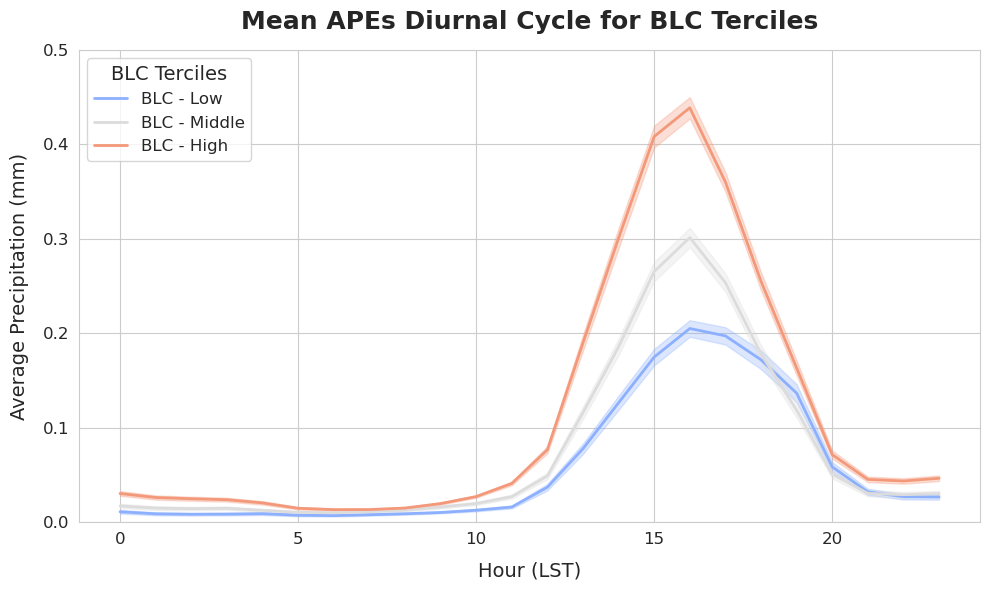

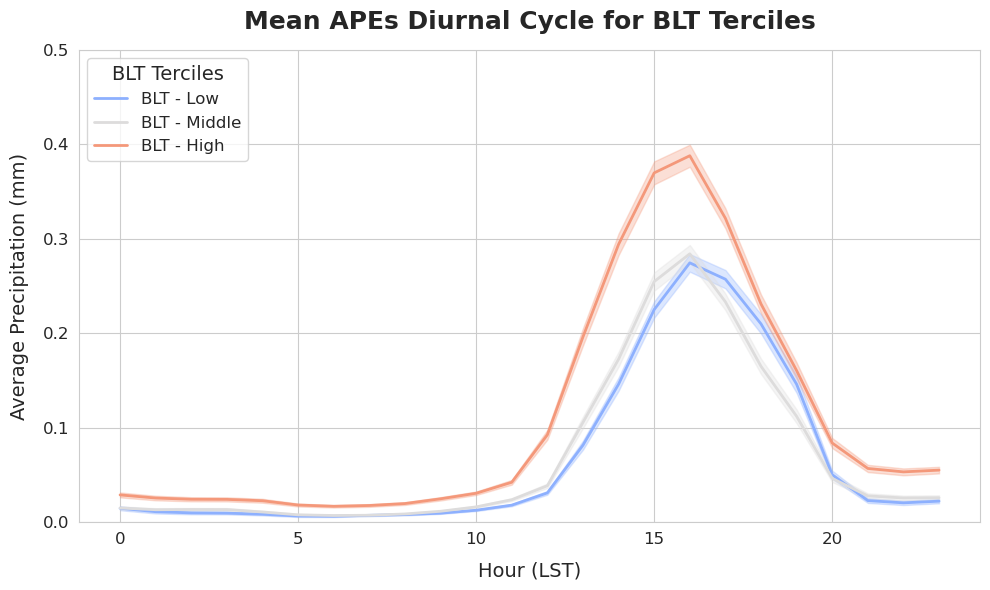

In [51]:
# Set the style
sns.set_style("whitegrid")

# Calculate the terciles for the 'blc' and 'blt' columns
blc_terciles = np.percentile(apes['blc'].dropna(), [33, 66])
blt_terciles = np.percentile(apes['blt'].dropna(), [33, 66])

# Categorize the data into three terciles for 'blc' and 'blt'
apes.loc[:, 'blc_tercile'] = np.digitize(apes['blc'], bins=[-np.inf, blc_terciles[0], blc_terciles[1], np.inf])
apes.loc[:, 'blt_tercile'] = np.digitize(apes['blt'], bins=[-np.inf, blt_terciles[0], blt_terciles[1], np.inf])

# Function to calculate mean and 95% confidence interval
def compute_ci(x):
    if len(x) > 1:  # Avoid division by zero
        mean = np.nanmean(np.array(x.tolist()), axis=0)
        std = np.nanstd(np.array(x.tolist()), axis=0)
        n = len(x)
        ci = 1.96 * (std / np.sqrt(n))  # 95% Confidence Interval
        return mean, ci
    else:
        return np.nan, np.nan

# Calculate average precipitation and confidence interval for each tercile
precip_stats_blc = apes.groupby('blc_tercile')['daily_precip'].apply(compute_ci)
precip_stats_blt = apes.groupby('blt_tercile')['daily_precip'].apply(compute_ci)

# Create labels for the terciles
tercile_labels = {1: 'Low', 2: 'Middle', 3: 'High'}

colors = sns.color_palette("coolwarm", 3)  # A cool-to-warm color palette with three colors

# Plotting for BLC
fig, ax = plt.subplots(figsize=(10, 6))

for tercile, (precip_avg, precip_ci) in precip_stats_blc.items():
    x_values = np.arange(len(precip_avg))  # Ensure correct x-axis indexing
    
    ax.fill_between(x_values, precip_avg - precip_ci, precip_avg + precip_ci, 
                    color=colors[tercile-1], alpha=0.3)
    
    ax.plot(x_values, precip_avg, label=f'BLC - {tercile_labels[tercile]}', 
            linewidth=2, color=colors[tercile-1])

ax.set_title('Mean APEs Diurnal Cycle for BLC Terciles', fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel('Hour (LST)', fontsize=14, labelpad=10)
ax.set_ylabel('Average Precipitation (mm)', fontsize=14, labelpad=10)
ax.legend(title="BLC Terciles", fontsize=12, title_fontsize=14, loc='upper left', frameon=True)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.show()

# Plotting for BLT
fig, ax = plt.subplots(figsize=(10, 6))

for tercile, (precip_avg, precip_ci) in precip_stats_blt.items():
    x_values = np.arange(len(precip_avg))  # Ensure correct x-axis indexing
    
    ax.fill_between(x_values, precip_avg - precip_ci, precip_avg + precip_ci, 
                    color=colors[tercile-1], alpha=0.3)
    
    ax.plot(x_values, precip_avg, label=f'BLT - {tercile_labels[tercile]}', 
            linewidth=2, color=colors[tercile-1])

ax.set_title('Mean APEs Diurnal Cycle for BLT Terciles', fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel('Hour (LST)', fontsize=14, labelpad=10)
ax.set_ylabel('Average Precipitation (mm)', fontsize=14, labelpad=10)
ax.legend(title="BLT Terciles", fontsize=12, title_fontsize=14, loc='upper left', frameon=True)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.show()



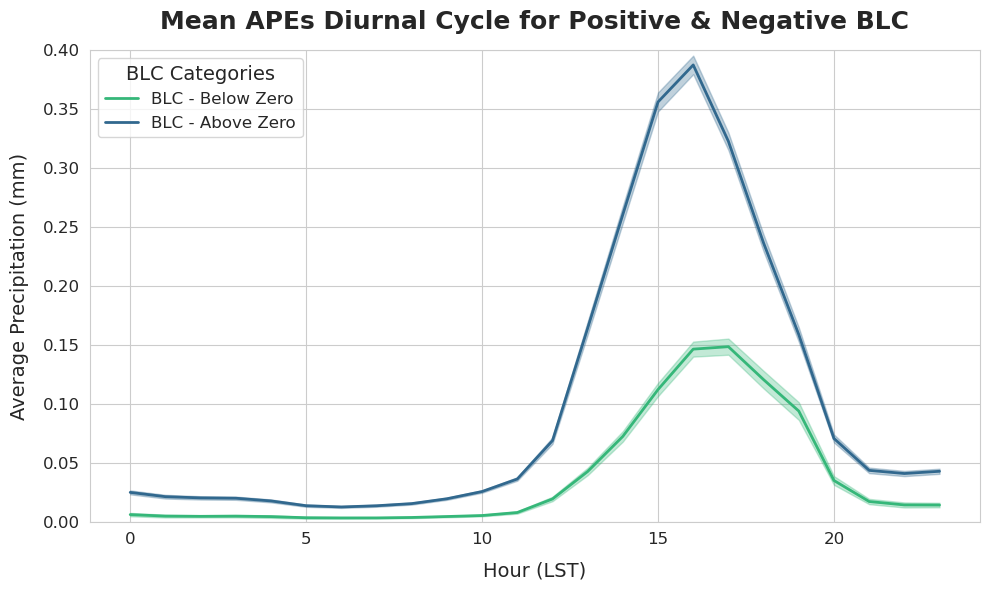

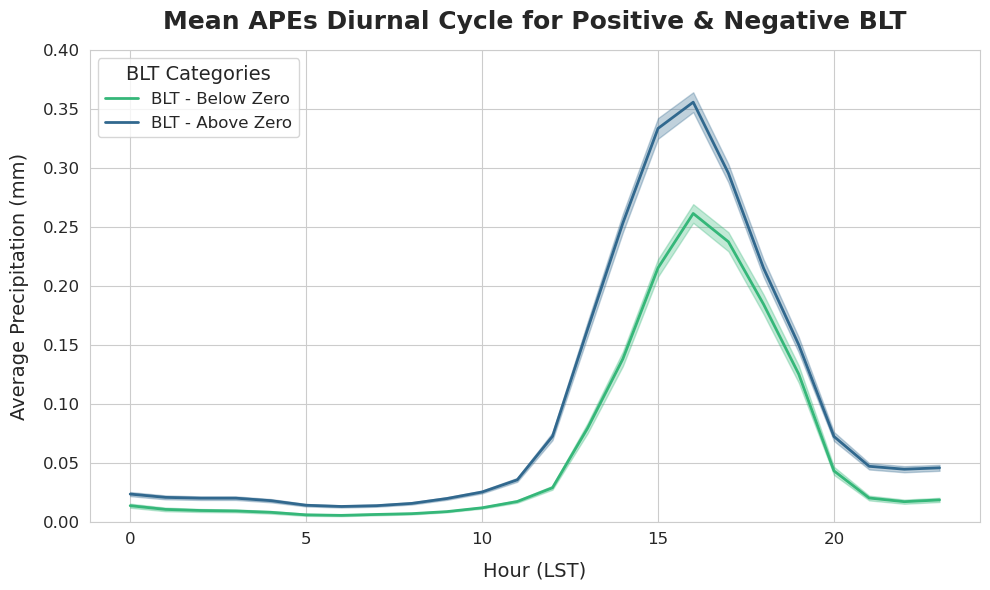

In [54]:
# Set the style
sns.set_style("whitegrid")

apes.loc[:, 'blc_category'] = np.where(apes['blc_stnd_anom'] > 0, 'Positive', 'Negative')

apes.loc[:, 'blt_category'] = np.where(apes['blt_stnd_anom'] > 0, 'Positive', 'Negative')

# Function to calculate mean and 95% confidence interval
def compute_ci(x):
    if len(x) > 1:  # Avoid division by zero
        mean = np.nanmean(np.array(x.tolist()), axis=0)
        std = np.nanstd(np.array(x.tolist()), axis=0)
        n = len(x)
        ci = 1.96 * (std / np.sqrt(n))  # 95% Confidence Interval
        return mean, ci
    else:
        return np.nan, np.nan

# Calculate average precipitation and confidence interval for each category for 'blc' and 'blt'
precip_stats_blc = apes.groupby('blc_category')['daily_precip'].apply(compute_ci)

precip_stats_blt = apes.groupby('blt_category')['daily_precip'].apply(compute_ci)

# Category labels
category_labels = {'Positive': 'Above Zero', 'Negative': 'Below Zero'}

# Color palette for the categories
colors = sns.color_palette("viridis", 2)  # Distinct color mapping for two categories

# Plotting for BLC
fig, ax = plt.subplots(figsize=(10, 6))

for category, (precip_avg, precip_ci) in precip_stats_blc.items():
    x_values = np.arange(len(precip_avg))  # Ensure correct x-axis indexing
    ax.fill_between(x_values, precip_avg - precip_ci, precip_avg + precip_ci, 
                    color=colors[0] if category == 'Positive' else colors[1], alpha=0.3)
    ax.plot(x_values, precip_avg, label=f'BLC - {category_labels[category]}', 
            linewidth=2, color=colors[0] if category == 'Positive' else colors[1])

ax.set_title('Mean APEs Diurnal Cycle for Positive & Negative BLC', fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel('Hour (LST)', fontsize=14, labelpad=10)
ax.set_ylabel('Average Precipitation (mm)', fontsize=14, labelpad=10)
ax.legend(title="BLC Categories", fontsize=12, title_fontsize=14, loc='upper left', frameon=True)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylim(0, 0.4)
plt.tight_layout()
plt.show()

# Plotting for BLT
fig, ax = plt.subplots(figsize=(10, 6))

for category, (precip_avg, precip_ci) in precip_stats_blt.items():
    x_values = np.arange(len(precip_avg))  
    ax.fill_between(x_values, precip_avg - precip_ci, precip_avg + precip_ci, 
                    color=colors[0] if category == 'Positive' else colors[1], alpha=0.3)
    ax.plot(x_values, precip_avg, label=f'BLT - {category_labels[category]}', 
            linewidth=2, color=colors[0] if category == 'Positive' else colors[1])

ax.set_title('Mean APEs Diurnal Cycle for Positive & Negative BLT', fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel('Hour (LST)', fontsize=14, labelpad=10)
ax.set_ylabel('Average Precipitation (mm)', fontsize=14, labelpad=10)
ax.legend(title="BLT Categories", fontsize=12, title_fontsize=14, loc='upper left', frameon=True)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylim(0, 0.4)
plt.tight_layout()
plt.show()


In [84]:
# t-test

# Ensure daily_precip is stored as a NumPy array
apes['daily_precip'] = apes['daily_precip'].apply(np.array)

# Separate data into groups based on blc_category
positive_group = apes[apes['blc_category'] == 'Positive']['daily_precip'].to_list()

negative_group = apes[apes['blc_category'] == 'Negative']['daily_precip'].to_list()

positive_group = np.vstack(positive_group)  # Shape (num_days, 24)

negative_group = np.vstack(negative_group)

t_stats, p_values = stats.ttest_ind(positive_group, negative_group, axis=0, nan_policy='omit')

t_test_results = pd.DataFrame({'hour': np.arange(24), 't_stat': t_stats, 'p_value': p_values})

/tmp/ipykernel_6896/3361771428.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apes['daily_precip'] = apes['daily_precip'].apply(np.array)


0.4180798027268016

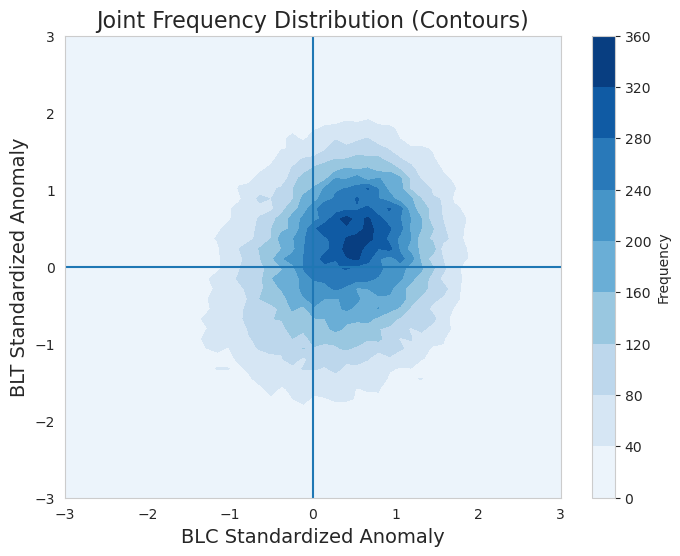

In [24]:
# Set up the figure

plt.figure(figsize=(8, 6))

hist, xedges, yedges = np.histogram2d(apes['blc_stnd_anom'], 
                                      
                                      apes['blt_stnd_anom'], bins=50)

plt.contourf(xedges[:-1], yedges[:-1], hist.T, levels=10, cmap='Blues')

plt.xlabel('BLC Standardized Anomaly', fontsize=14)

plt.ylabel('BLT Standardized Anomaly', fontsize=14)

plt.title('Joint Frequency Distribution (Contours)', fontsize=16)

# Add colorbar
plt.colorbar(label='Frequency')

plt.grid(True)

plt.vlines(x=0, ymin=np.min(yedges), ymax=np.max(yedges))

plt.hlines(y=0, xmin=np.min(xedges), xmax=np.max(xedges))

plt.xlim(-3, 3)

plt.ylim(-3, 3)

plt.show()


## k means

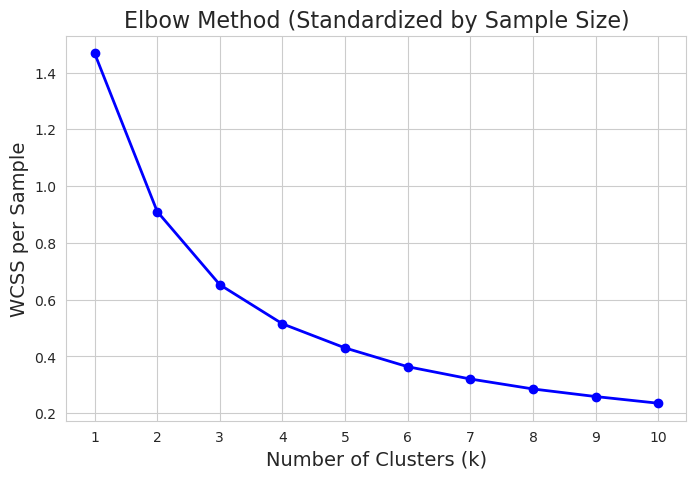

In [25]:
X = apes[['blt_stnd_anom', 'blc_stnd_anom']].dropna().values  # Use non-NaN values

wcss_per_sample = []

K_range = range(1, 11)  # Test k from 1 to 10

for k in K_range:
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    kmeans.fit(X)
    
    wcss_per_sample.append(kmeans.inertia_ / len(X))  # Standardized by total sample size

plt.figure(figsize=(8, 5))

plt.plot(K_range, wcss_per_sample, marker='o', linestyle='-', color='b', linewidth=2)

plt.xlabel('Number of Clusters (k)', fontsize=14)

plt.ylabel('WCSS per Sample', fontsize=14)

plt.title('Elbow Method (Standardized by Sample Size)', fontsize=16)

plt.grid(True)

plt.xticks(K_range)

plt.show()

/tmp/ipykernel_6896/2467124049.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apes.loc[apes.index.isin(features.index), 'cluster'] = clusters


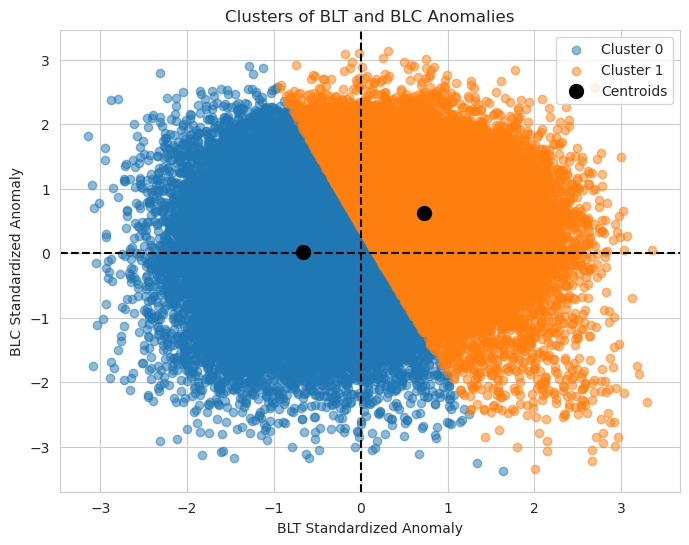

In [26]:
features = apes[['blt_stnd_anom', 'blc_stnd_anom']].dropna()

num_clusters = 2

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

clusters = kmeans.fit_predict(features)

apes.loc[apes.index.isin(features.index), 'cluster'] = clusters

plt.figure(figsize=(8, 6))

for i in range(num_clusters):
    
    plt.scatter(features.loc[clusters == i, 'blt_stnd_anom'],  
                
                features.loc[clusters == i, 'blc_stnd_anom'], 
                
                label=f'Cluster {i}', alpha=0.5)

plt.scatter(kmeans.cluster_centers_[:, 0], 
            
            kmeans.cluster_centers_[:, 1], 
            
            color='black', marker='o', s=100, label='Centroids')

plt.axvline(0, color='black', linestyle='--')

plt.axhline(0, color='black', linestyle='--')

plt.xlabel('BLT Standardized Anomaly')

plt.ylabel('BLC Standardized Anomaly')

plt.title('Clusters of BLT and BLC Anomalies')

plt.legend()

plt.grid(True)

plt.show()

In [27]:
sil_score = silhouette_score(features, clusters)

print(f'Silhouette Score: {sil_score:.3f}')

Silhouette Score: 0.356


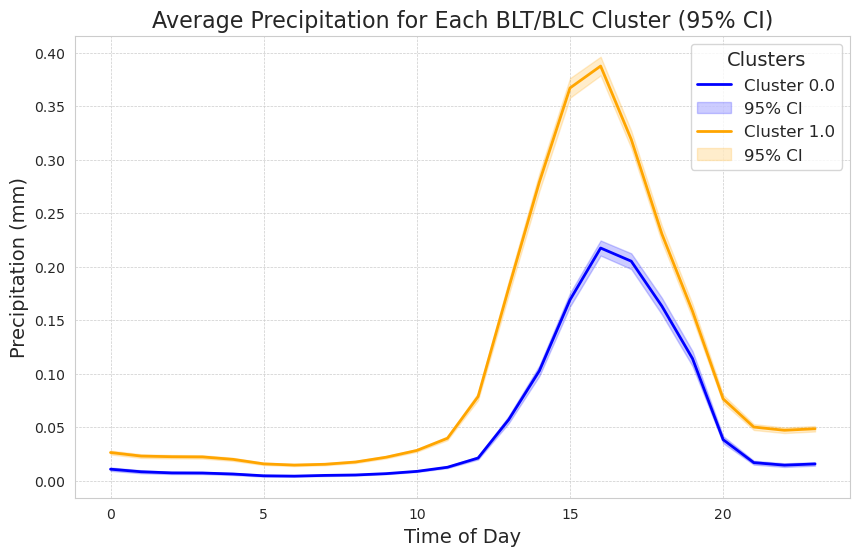

In [63]:
confidence_level = 0.95  # 95% Confidence Interval

precip_stats = apes.groupby('cluster')['daily_precip'].apply(
    
    lambda x: (
        
        np.nanmean(np.array(x.tolist()), axis=0),  # Mean precipitation
        
        stats.t.ppf((1 + confidence_level) / 2, df=np.sum(~np.isnan(np.array(x.tolist())), axis=0) - 1) * 
        
        np.nanstd(np.array(x.tolist()), axis=0) / np.sqrt(np.sum(~np.isnan(np.array(x.tolist())), axis=0))  # 95% CI
    )
)

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['blue', 'orange', 'green', 'red']  

for i, (cluster, (precip_avg, precip_ci)) in enumerate(precip_stats.items()):
    ax.plot(precip_avg, label=f'Cluster {cluster}', linewidth=2, color=colors[i])
    
    ax.fill_between(range(len(precip_avg)), 
                    precip_avg - precip_ci, 
                    precip_avg + precip_ci, 
                    color=colors[i], alpha=0.2, label="95% CI")

ax.set_title('Average Precipitation for Each BLT/BLC Cluster (95% CI)', fontsize=16)

ax.set_xlabel('Time of Day', fontsize=14)

ax.set_ylabel('Precipitation (mm)', fontsize=14)

ax.legend(title="Clusters", fontsize=12, title_fontsize=14)

ax.grid(True, linestyle='--', linewidth=0.5)

plt.show()
